# Introduction

In addition to functional summaries like the persistence landscape and persistent silhouette, we introduce the life entropy curve as an alternative vectorization method for persistence diagrams. While the landscape captures the shape of topological features and the silhouette provides a weighted average across birth–death intervals, the life entropy curve offers a **time-dependent measure** of the information content carried by persistent features.

It extends the idea of persistent entropy, defined as:
$$
E = -\sum_{[p, q] \in B} \left( \frac{q - p}{L} \right) \log\left( \frac{q - p}{L} \right)
$$

where $L=\sum_ {[p, q] \in B} (p-q)$  is the total lifespan of all bars in the persistence diagram $B$. This scalar summarizes the diversity of lifespans $-$ higher values indicate a more uniform distribution of interval lengths.

The **life entropy curve** (also called the *entropy summary function*) refines this idea by expressing entropy as a function over filtration scale $t$:

$$
S(t) = -\sum_{[p, q] \in B} \mathbf{1}_{[p \leq t < q]} \cdot \left( \frac{q - p}{L} \right) \log\left( \frac{q - p}{L} \right)
$$

This function captures the entropy contribution of features that are alive at each time $t$, giving a more detailed and dynamic view of the topological complexity.

By comparing life entropy curves across datasets, we gain insights not only into the presence of persistent features but also into how informational diversity evolves across scales.

# Preprocessing

### Loading Libraries

In [1]:
import tmd
from tmd.view import plot
from tmd.view import view

import matplotlib.pyplot as plt
import numpy as np
import os
import functions as fcts

from scipy.stats import ttest_ind

### Loading and checking the data

In [2]:
data_folder = "Data/ExamplesL23PC"
folders_to_treat = ['Human','Mouse']

In [3]:
grouped_neurons = fcts.check_and_load_neurons(data_folder, folders_to_treat)

Folder: Human
Neurons loaded: 186
Total files in folder: 187
.asc files in folder: 186
Failed to load: 0 files
Unloaded files: []

Folder: Mouse
Neurons loaded: 38
Total files in folder: 39
.asc files in folder: 38
Failed to load: 0 files
Unloaded files: []



### Persistence Diagram

<div class="alert alert-block alert-success">
    
In the following box, we can modify multiple parameters:
- **region** (`neuron_part`): can either be *basal_dendrite*, *apical_dendrite*, *axon* or *dendrites*. It depends on which part of the neuron with want to take into account
- **distance** (`distance_type`): could either be *radial_distances* or *path_distances*

</div>

In [1]:
region = "apical_dendrite"
distance = "path_distances"

In [4]:
neurons_human = grouped_neurons["Human"]
neurons_mouse = grouped_neurons["Mouse"]

# Computing persistence diagram for humans (gives the list of the coordinates of all the persictence diagrams)
ph_diagrams_human = fcts.compute_diagrams(
    neurons_human, 
    group_name = "Human", 
    neuron_part = region ,
    distance_type = distance 
)

# Computing persistence diagram for mouses
ph_diagrams_mouse = fcts.compute_diagrams(
    neurons_mouse, 
    group_name = "Mouse", 
    neuron_part = region,
    distance_type= distance 
)

[Human] Computed 186 persistence diagrams for basal_dendrites.
[Mouse] Computed 38 persistence diagrams for basal_dendrites.


# Computing Persistence Entropy and Entropy Life Curve

In [18]:
entropy_human = [fcts.compute_persistence_entropy(diag) for diag in ph_diagrams_human]
entropy_mouse = [fcts.compute_persistence_entropy(diag) for diag in ph_diagrams_mouse]

mean_human_entropy = np.mean(entropy_human)
mean_mouse_entropy = np.mean(entropy_mouse)

std_human_entropy = np.std(entropy_human)
std_mouse_entropy = np.std(entropy_mouse)

print("Mean Persistence Entropy (Human):", mean_human_entropy)
print("Mean Persistence Entropy (Mouse):", mean_mouse_entropy)
print("Standard Deviation Entropy (Human):", std_human_entropy)
print("Standard Deviation Entropy (Mouse):", std_mouse_entropy)

Mean Persistence Entropy (Human): 3.195120263385209
Mean Persistence Entropy (Mouse): 3.0129231856123524
Standard Deviation Entropy (Human): 0.5071520525981847
Standard Deviation Entropy (Mouse): 0.3954881285169387


In [6]:
bins = np.linspace(0, 1000, 30)

## <span style="color:hotpink">Mouse</span> 

In [7]:
life_entropy_mouse = []

for i in range(len(ph_diagrams_mouse)):
    entropy_mouse = tmd.vectorizations.life_entropy_curve(ph_diagrams_mouse[i], bins)[0]
    life_entropy_mouse.append(entropy_mouse)

In [8]:
len(life_entropy_mouse)

38

## <span style="color:lightseagreen">Human </span> 

In [10]:
life_entropy_human = []

for i in range(len(ph_diagrams_human)):
    entropy_human = tmd.vectorizations.life_entropy_curve(ph_diagrams_human[i], bins)[0]
    life_entropy_human.append(entropy_human)

In [11]:
len(life_entropy_human)

186

# Plot Entropies

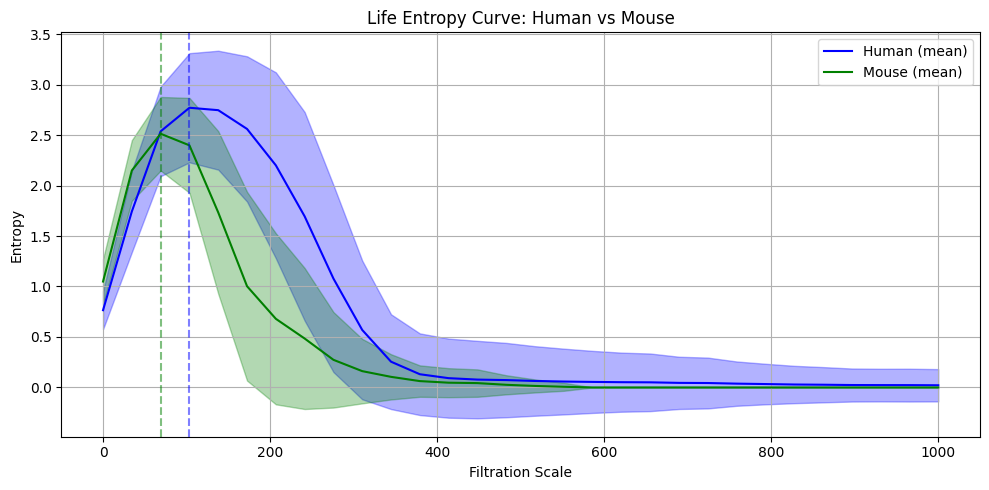

In [13]:
# Create the plot
plt.figure(figsize=(10, 5))
fcts.plot_entropy_summary(life_entropy_human, bins, "Human", "blue")
fcts.plot_entropy_summary(life_entropy_mouse, bins, "Mouse", "green")

plt.title("Life Entropy Curve: Human vs Mouse")
plt.xlabel("Filtration Scale")
plt.ylabel("Entropy")
plt.legend()

# Find bin where mean entropy is maximal
human_peak = bins[np.nanargmax(np.nanmean(life_entropy_human, axis=0))]
mouse_peak = bins[np.nanargmax(np.nanmean(life_entropy_mouse, axis=0))]

# Add vertical lines
plt.axvline(human_peak, color='blue', linestyle='--', alpha=0.5, label="Human peak")
plt.axvline(mouse_peak, color='green', linestyle='--', alpha=0.5, label="Mouse peak")

plt.grid(True)
plt.tight_layout()

#plt.savefig("Images/entropy_plot_"+region+".png", dpi=300, bbox_inches="tight")

plt.show()

The higher entropy curve for human neurons suggests a more balanced distribution of topological feature lifespans, indicating a potentially richer morphological structure compared to mouse neurons. The sharp decay for mouse morphologies may reflect more short-lived topological features dominating the signal.

### AUC Comparison: Area Under the Curve

In [14]:
# Compute mean curves
mean_human = np.nanmean(life_entropy_human, axis=0)
mean_mouse = np.nanmean(life_entropy_mouse, axis=0)

# Area under the curve using trapezoidal rule
auc_human = np.trapz(mean_human, bins)
auc_mouse = np.trapz(mean_mouse, bins)

print(f"AUC (Human): {auc_human:.3f}")
print(f"AUC (Mouse): {auc_mouse:.3f}")


AUC (Human): 672.018
AUC (Mouse): 421.558


### Statistical Comparison

To statistically compare the total topological entropy between human and mouse neurons, we used the *Welch t-test*, which is appropriate when the two groups have unequal sample sizes and potentially different variances. This choice is justified by the structure of our data: we have 186 human and 38 mouse neurons, and the entropy curves showed notable differences in variability between the groups. Unlike the standard Student's t-test, Welch’s test does not assume equal variances, making it more robust and reliable in this context.

In [15]:
# Compute AUCs for each individual curve
auc_human_all = [np.trapz(curve, bins) for curve in life_entropy_human]
auc_mouse_all = [np.trapz(curve, bins) for curve in life_entropy_mouse]

# t-test (Welch)
t_stat, p_val = ttest_ind(auc_human_all, auc_mouse_all, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")


t = 8.360, p = 0.0000


We compared the area under the life entropy curves (AUC) for human and mouse neurons as a measure of total topological complexity across filtration. The average AUC for human neurons was significantly higher (≈ 869) than for mouse neurons (≈ 490).
A Welch t-test confirmed the significance of this difference (**t = 13.45, p < 0.0001**), suggesting that human neuronal morphologies support more persistent and diverse topological features across scales.